# Medical Imaging Preprocessing

> A walk-through tutorial how to process, manipulate, and save medical images. 
- toc: true
- use_math: true
- comments: true
- use_plotly: true

- read dicom
- metadata
- resampling
- segmentation (by HU)

# Background

In this tutorial, we will review how to process, handle, and save DICOM data. A great resource to access medical imaging data is through the [Cancer Imaging Archive](https://www.cancerimagingarchive.net/collections/). They maintain an archive of medical images across various datasets that are accessible for public download. We will be using scans from the [LIDC-IDRI](https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX) dataset which contains diagnostic and lung cancer screening thoracic computed tomography (CT) scans with annotated lesions in XML format. To handle the annotated lessions, researchers have developed the [pylidc](https://pylidc.github.io/tuts/scan.html) for processing the XML files. 

In [1]:
#hide
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom

from pathlib import Path

In [2]:
#hide
PATH = 'data/LIDC-IDRI/'

patients = os.listdir(PATH)
patients.sort()
print(patients.pop(0))
patients

.ipynb_checkpoints


['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011']

In [3]:
#hide
# not all patient sub-folders contain CT scan, sometimes they're RTSTRUCTs 

patient_path = []
for p in patients:
    patient_directory = glob.glob(f"{PATH}/{p}/**/")
    for mod in patient_directory:
        mod_files = glob.glob(f"{mod}/**/**")
        if len(mod_files) > 10: patient_path.append(mod)
patient_path

['data/LIDC-IDRI//LIDC-IDRI-0001/01-01-2000-NA-NA-30178/',
 'data/LIDC-IDRI//LIDC-IDRI-0002/01-01-2000-NA-NA-98329/',
 'data/LIDC-IDRI//LIDC-IDRI-0003/01-01-2000-NA-NA-94866/',
 'data/LIDC-IDRI//LIDC-IDRI-0004/01-01-2000-NA-NA-91780/',
 'data/LIDC-IDRI//LIDC-IDRI-0005/01-01-2000-NA-NA-42125/',
 'data/LIDC-IDRI//LIDC-IDRI-0006/01-01-2000-NA-NA-92500/',
 'data/LIDC-IDRI//LIDC-IDRI-0007/01-01-2000-NA-NA-81781/',
 'data/LIDC-IDRI//LIDC-IDRI-0008/01-01-2000-NA-NA-30141/',
 'data/LIDC-IDRI//LIDC-IDRI-0009/01-01-2000-NA-NA-07045/',
 'data/LIDC-IDRI//LIDC-IDRI-0010/01-01-2000-NA-NA-43375/',
 'data/LIDC-IDRI//LIDC-IDRI-0011/01-01-2000-NA-NA-73568/']

Without going into intensive detail, we should know that CT scans produce an image by producing cross-sectional images from an X-Ray and then reconstructing the slices. Each slice is saved to a DICOM file which stores the pixel array and metadata for that particular slice. We can then sort the list of DICOM files by the image position of the patient to construct a volume image and the sort the slices in ascending order. If you're interested in learning about the physics of medical imaging and how images are produced, I recommend [Fundamentals of Medical Imaging](https://doi.org/10.1017/CBO9780511596803).

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(f"{s}") for s in glob.glob(f"{path}/**/*.dcm")]
    # sort slices vertically - bottom up
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

We can now load the DICOM files for the first patient. Looking at the first DICOM file, we can see all the metadata information that is stored. We'll need this to process and store our data in a more appropriate format.

In [5]:
scan = load_scan(patient_path[0])
scan[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.227129408140157230270926028555
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.22712

Digital Imaging and Communications in Medicine or DICOM is a standardized file format for medical imaging information and related data. Typically, you will see the raw medical images stored in this format and later processed to an easier to handle format such as [NIfTI](https://radiopaedia.org/articles/nifti-file-format#:~:text=NIfTI%20is%20a%20type%20of,neuroscience%20and%20even%20neuroradiology%20research.) or [Nrrd](http://teem.sourceforge.net/nrrd/format.html). To process our DICOM files, we are using the ```pydicom``` library and have constructed and read a list of ```pydicom.dataset.FileDataset``` objects with our ```scan``` list. This object allows to access any relevant data elements stored in the DICOM file, useful data elements include ```Modality, RescaleIntercept, RescaleSlope, PixelSpacing, SliceThickness,``` and ```ImagePositionPatient```. We'll need these data elements to standardize our scans to the same pixel spacing and covert our pixel values to the Hounsfield scale. It could also be helpful to use these data elements and construct an array of metadata elements to use for training. This is particularly useful in case you want to identify any subtleties between CT manufacturers. The [DICOM library](https://www.dicomlibrary.com/dicom/dicom-tags/) has an exhaustive list of all the data elements and there use. You will also notice the following standardized format for DICOM data elements:
- a tag that identifies the attribute, usually in the format (XXXX,XXXX) with hexadecimal numbers, and may be divided further into DICOM Group Number and DICOM Element Number;
- a DICOM Value Representation (VR) that describes the data type and format of the attribute value.

In [6]:
# ??pydicom.dataset.FileDataset

In [7]:
type(scan[0])

pydicom.dataset.FileDataset

In [49]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # check that every slice has same slope and intercept
    assert len(set([s.RescaleSlope for s in slices])) == 1
    assert len(set([s.RescaleIntercept for s in slices])) == 1
    
    # slope and intercept to convert to HU
    slope = scan[0].RescaleSlope
    intercept = scan[0].RescaleIntercept
    
    # Convert to Hounsfield units (HU)
    image = image.astype(np.float64) * slope
    image += np.int16(intercept)
    
    # Set outside-of-scan pixels to air
    # this step is completly optional
    # w/o it there'll be a cylinder around the body as seen in the DICOM pixel array below
    image[image < -1024] = -1024
    
    return np.array(image, dtype=np.int16)

After processing our pixel array and converting it to Hounsfield scale, we can check the distribution of pixels. The two distributions stem from the drastic differences in tissue properties in the acquire image. The air in the lungs and outside the body range from -1000 to -500 HU while more denser materials such as fat and cortical bone provide higher HU values of -100 to +3000 HU respectively.

scan_data.min()=-1024, scan_data.max()=3071


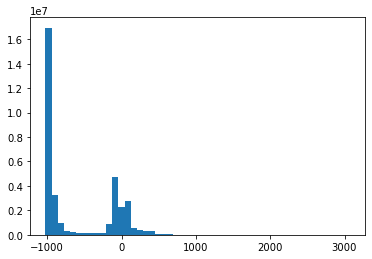

In [67]:
scan_data = get_pixels_hu(scan)
plt.hist(scan_data.ravel(), bins=50)
print(f"{scan_data.min()=}, {scan_data.max()=}")
plt.show()

Since we're working with grayscale images, the intensity of the black varies according to the minimum and maximum values. The black pixels in the HU images are equivalent (-1024 HU) to the pixels in the lung and outside the body for the raw DICOM pixel array. Since we masked all pixels < -1024, we no longer obtain a cylinder surrounding the body and set them all equivalent to air. If you're curious why we're obtaining a circle around each slice, it's because of the CT scan itself and how it emits and receives X-Rays all around the patient's body.

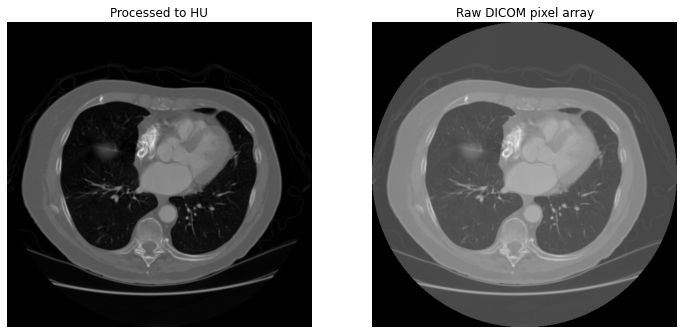

In [66]:
f, axs = plt.subplots(1,2, figsize=(12,12))

axs[0].imshow(scan_data[65,...], cmap=plt.cm.gray)
axs[0].set_title('Processed to HU')
axs[1].imshow(scan[65].pixel_array, cmap=plt.cm.gray)
axs[1].set_title('Raw DICOM pixel array')

for a in axs:
    a.axis('off')
    
f.show()